In [46]:
import json
import sys
import os
from collections import defaultdict
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.cluster import KMeans
import numpy as np
import json
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
sys.path.append(os.path.join('../pstal-etu/lib/'))
from conllulib import CoNLLUReader
from torch.utils.data import DataLoader
import random

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
path = '.'

# **MLP**

In [12]:

tokenizer = AutoTokenizer.from_pretrained('almanach/camembert-base')
model = AutoModel.from_pretrained('almanach/camembert-base')

file_train = os.path.join(path, '../pstal-etu/sequoia/sequoia-ud.parseme.frsemcor.simple.train')
file_test = os.path.join(path, '../pstal-etu/sequoia/sequoia-ud.parseme.frsemcor.simple.dev')



In [21]:
def dataloader(file, mapping = None):
    """
    Dataloader : charge un fichier CoNLLU, calcule des embeddings pour les mots
    et associe les embeddings aux labels. Si un mot est décomposé en tokens,
    l'embedding est la moyenne des embeddings des tokens du mot.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    data = []
    create_map = False
    if not mapping : 
        # ne pas mettre de mapping sur le train pour créer la map global et réutiliser le mapping du train sur le test et l'éval
        mapping = {}
        create_map = True
    with open(file, 'r') as file:
        reader = CoNLLUReader(file)
        for sent in reader.readConllu():
            mots = [tok["form"] for tok in sent]
            labels = [tok["frsemcor:noun"] for tok in sent]
            label_idx = [i for i in range(len(labels))]

            if create_map:
                for i in label_idx:
                    if labels[i] not in mapping:
                        mapping[labels[i]] = len(mapping)

            token_obj = tokenizer(mots, is_split_into_words=True, return_tensors='pt')
            word_ids = token_obj.word_ids()
            with torch.no_grad():
                embeddings = model(**token_obj)["last_hidden_state"]

            # calcul des embeddings moyens par mot
            word_embeddings = []
            for word_idx in range(len(mots)):
                token_indices = [i for i, w_id in enumerate(word_ids) if w_id == word_idx]
                if token_indices:
                    avg_embedding = embeddings[:, token_indices, :].mean(dim=1).squeeze(0)
                    word_embeddings.append(avg_embedding)
                else:
                    word_embeddings.append(torch.zeros(embeddings.size(-1)).to(device)) 

            # associer les embeddings moyens aux labels
            for i in label_idx:
                if labels[i] in mapping: 
                    data.append((word_embeddings[i], mapping[labels[i]]))
    return data, mapping

In [15]:
class MLP(nn.Module):
    def __init__(self, embedding_size, h1, h2, nb_tags):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=embedding_size, out_features=h1)
        self.fc2 = nn.Linear(in_features=h1, out_features=h2)
        self.fc3 = nn.Linear(in_features=h2, out_features=nb_tags)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [16]:
def train_with_metrics(model_nn, trainloader, validateloader, loss_fn, n_epochs, optimizer):
    """
    Fonction d'entraînement du modèle avec calcul d'accuracy.
    :param model_nn: modèle de type nn.Module
    :param trainloader: DataLoader pour l'entraînement
    :param validateloader: DataLoader pour la validation
    :param loss_fn: fonction de perte
    :param n_epochs: nombre d'époques
    :param optimizer: optimiseur
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_nn = model_nn.to(device)
    losses = []
    accuracies = []

    for epoch in range(n_epochs):
        # entraînement
        model_nn.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model_nn(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == targets).sum().item()
            total_train += targets.size(0)
        train_accuracy = correct_train / total_train

        #  validation
        model_nn.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in validateloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model_nn(inputs)
                val_loss += loss_fn(outputs, targets).item()
                preds = torch.argmax(outputs, dim=1)
                correct_val += (preds == targets).sum().item()
                total_val += targets.size(0)
        val_accuracy = correct_val / total_val
        
        train_loss /= len(trainloader)
        val_loss /= len(validateloader)
        losses.append(val_loss)
        accuracies.append(val_accuracy)

        print(f"Époque {epoch + 1}/{n_epochs} : "
              f"Perte entraînement = {train_loss:.4f}, "
              f"Accuracy entraînement = {train_accuracy:.4f}, "
              f"Perte validation = {val_loss:.4f}, "
              f"Accuracy validation = {val_accuracy:.4f}")

    print("Entraînement terminé.")
    return losses, accuracies


Proportion: 0.2, Expérience: 1/1
Époque 1/10 : Perte entraînement = 1.1025, Accuracy entraînement = 0.7842, Perte validation = 0.8536, Accuracy validation = 0.7916
Époque 2/10 : Perte entraînement = 0.7654, Accuracy entraînement = 0.7928, Perte validation = 0.7607, Accuracy validation = 0.7937
Époque 3/10 : Perte entraînement = 0.6902, Accuracy entraînement = 0.7985, Perte validation = 0.7072, Accuracy validation = 0.8002
Époque 4/10 : Perte entraînement = 0.6511, Accuracy entraînement = 0.8113, Perte validation = 0.6847, Accuracy validation = 0.7994
Époque 5/10 : Perte entraînement = 0.6296, Accuracy entraînement = 0.8168, Perte validation = 0.6614, Accuracy validation = 0.8145
Époque 6/10 : Perte entraînement = 0.5972, Accuracy entraînement = 0.8257, Perte validation = 0.6418, Accuracy validation = 0.8169
Époque 7/10 : Perte entraînement = 0.5653, Accuracy entraînement = 0.8340, Perte validation = 0.6129, Accuracy validation = 0.8225
Époque 8/10 : Perte entraînement = 0.5320, Accurac

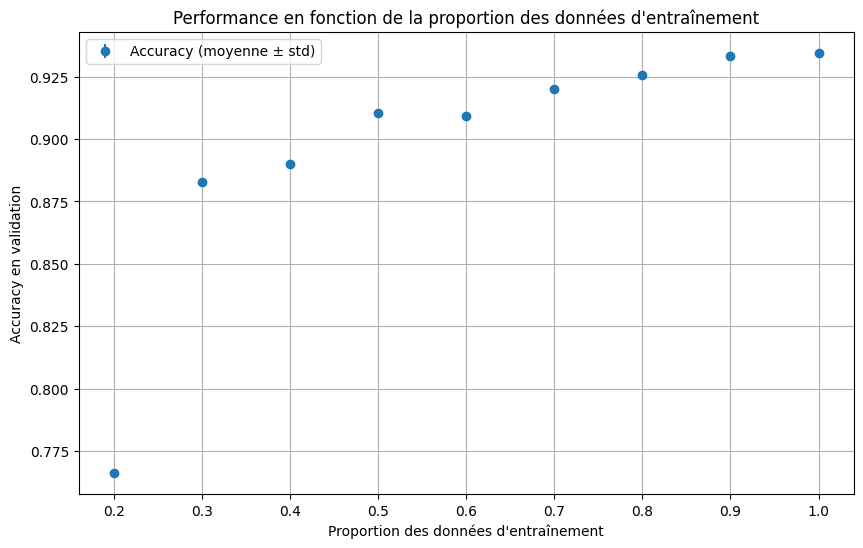

In [22]:
data_train, mapping = dataloader(file_train)
data_eval, _ = dataloader(file_test, mapping)

proportions = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
num_experiments = 1  # Nombre de répétitions par proportion

all_accuracies = []
res = defaultdict(list)
# Boucle sur les proportions
for proportion in proportions:
    proportion_accuracies = []

    for experiment in range(num_experiments):
        print(f"Proportion: {proportion}, Expérience: {experiment + 1}/{num_experiments}")

        # Création des sous-ensembles de données d'entraînement
        subset_size = int(len(data_train) * proportion)
        subset_train = data_train[:subset_size]
        trainloader = DataLoader(subset_train, batch_size=10, shuffle=True)
        evalloader = DataLoader(data_eval, batch_size=10, shuffle=True)

        # Initialisation du modèle et des paramètres
        mlp = MLP(768, 200, 200, len(mapping))
        optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01)
        loss = nn.CrossEntropyLoss()

        # Entraînement
        _, accuracies = train_with_metrics(mlp, trainloader, evalloader, loss, 10, optimizer)

        # Stockage du dernier score d'accuracy
        proportion_accuracies.append(accuracies[-1])
        res[proportion].append(accuracies[-1])

    # Ajout des résultats pour cette proportion
    all_accuracies.append((proportion, np.mean(proportion_accuracies), np.std(proportion_accuracies)))

# Graphique des résultats
proportions, mean_accuracies, std_accuracies = zip(*all_accuracies)

plt.figure(figsize=(10, 6))
plt.errorbar(proportions, mean_accuracies, yerr=std_accuracies, fmt='o', label="Accuracy (moyenne ± std)")
plt.title("Performance en fonction de la proportion des données d'entraînement")
plt.xlabel("Proportion des données d'entraînement")
plt.ylabel("Accuracy en validation")
plt.legend()
plt.grid()
plt.show()


torch.save(mlp, "mlp.pth")
mapping = dict(mapping)
with open("mapping.json", "w") as file: 
    json.dump(mapping, file, indent=4)


In [20]:
data_train, mapping = dataloader(file_train)
data_eval, _ = dataloader(file_test)
print(mapping)
print(_)

{'Person': 0, '*': 1, 'Act': 2, 'Time': 3, 'Institution': 4, 'Artifact': 5, 'Object': 6, 'State': 7, 'Cognition': 8, 'Feeling': 9, 'Plant': 10, 'Substance': 11, 'Part': 12, 'Attribute': 13, 'Possession': 14, 'Quantity': 15, 'Event': 16, 'Group': 17, 'Animal': 18, 'Food': 19, 'Phenomenon': 20, 'Communication': 21, 'Relation': 22, 'Body': 23, 'Tops': 24}
{'*': 0, 'Institution': 1, 'Artifact': 2, 'Act': 3, 'Person': 4, 'Cognition': 5, 'Time': 6, 'Object': 7, 'Phenomenon': 8, 'Feeling': 9, 'Quantity': 10, 'Event': 11, 'Part': 12, 'Relation': 13, 'State': 14, 'Substance': 15, 'Possession': 16, 'Attribute': 17, 'Communication': 18, 'Plant': 19, 'Food': 20, 'Group': 21, 'Body': 22, 'Animal': 23, 'Tops': 24}


# **K-mean**

In [33]:
model = AutoModel.from_pretrained('almanach/camembert-base')
tokenizer = AutoTokenizer.from_pretrained('almanach/camembert-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with open("embeddings.json", "r") as file:
    train_data = json.load(file)
with open("mapping.json", "r") as file:
    mapping = json.load(file)

In [31]:
def dataloader_test(file):
    test_data = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    with open(file, 'r') as f:
        reader = CoNLLUReader(f)
        for sent in reader.readConllu():
            mots = [tok["form"] for tok in sent]
            labels = [tok.get("frsemcor:noun", "") for tok in sent]
            token_obj = tokenizer(mots, is_split_into_words=True, return_tensors='pt').to(device)
            word_ids = token_obj.word_ids()
            
            with torch.no_grad():
                embeddings = model(**token_obj)["last_hidden_state"].to(device)
            
            for word_idx in range(len(mots)):
                token_indices = [i for i, w_id in enumerate(word_ids) if w_id == word_idx]
                if token_indices:
                    avg_embedding = embeddings[:, token_indices, :].mean(dim=1).squeeze(0).cpu().numpy()
                    
                    test_data.append({
                        "word": mots[word_idx],
                        "embedding": avg_embedding.tolist(),
                        "label": mapping.get(labels[word_idx], -1)
                    })
    return test_data

Proportion: 0.2
Proportion: 0.2
Proportion: 0.2
Proportion: 0.2
Proportion: 0.2


/home/baptiste/micromamba/envs/cours/lib/python3.10/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Proportion: 0.3
Proportion: 0.3
Proportion: 0.3
Proportion: 0.3
Proportion: 0.3
Proportion: 0.4
Proportion: 0.4
Proportion: 0.4
Proportion: 0.4
Proportion: 0.4
Proportion: 0.5
Proportion: 0.5
Proportion: 0.5
Proportion: 0.5
Proportion: 0.5
Proportion: 0.6
Proportion: 0.6
Proportion: 0.6
Proportion: 0.6
Proportion: 0.6
Proportion: 0.7
Proportion: 0.7
Proportion: 0.7
Proportion: 0.7
Proportion: 0.7
Proportion: 0.8
Proportion: 0.8
Proportion: 0.8
Proportion: 0.8
Proportion: 0.8
Proportion: 0.9
Proportion: 0.9
Proportion: 0.9
Proportion: 0.9
Proportion: 0.9
Proportion: 1.0
Proportion: 1.0
Proportion: 1.0
Proportion: 1.0
Proportion: 1.0


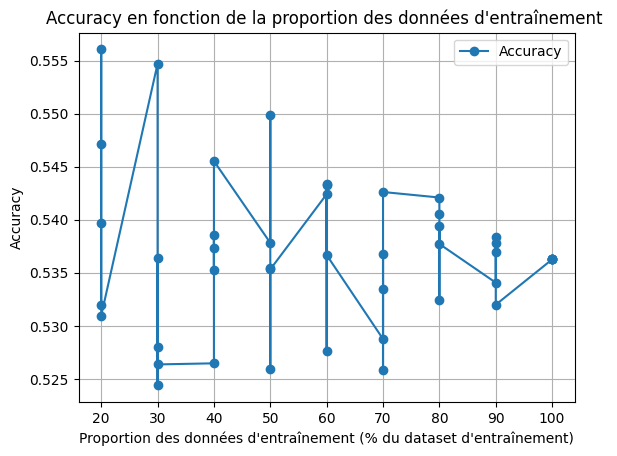

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
file_test = os.path.join(path, '../pstal-etu/sequoia/sequoia-ud.parseme.frsemcor.simple.test')
test_data = dataloader_test(file_test)
with open("mapping.json", "r") as file:
    mapping = json.load(file)
with open("embeddings.json", "r") as file:
    train_data = json.load(file)

proportions = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
accuracies = []

for proportion in proportions:
        for _ in range(5):
            proportion_accuracies = []
            print(f"Proportion: {proportion}")

            #  sous-ensembles de taille variable
            subset_size = int(len(train_data) * proportion)
            subset_train = random.sample(train_data, subset_size)

            num_classes = len(mapping)
            class_embeddings = {cls: [] for cls in range(num_classes)}
            for item in subset_train:
                class_embeddings[item["class"]].append(np.array(item["embedding"]))

            class_means = {
                cls: np.mean(embeddings, axis=0) if embeddings else np.zeros_like(train_data[0]["embedding"])
                for cls, embeddings in class_embeddings.items()
            } # embedding moyen par class 

            kmeans = KMeans(n_clusters=num_classes)
            train_embeddings = []
            train_labels = []
            for key, value in class_means.items():
                train_embeddings.append(value)
                train_labels.append(key)
            kmeans.fit(train_embeddings)

            # correspondance clusters et classes
            cluster_to_class = {}
            cluster_class_counts = defaultdict(lambda: defaultdict(int))
            for i, label in enumerate(train_labels):
                cluster = kmeans.labels_[i]
                cluster_class_counts[cluster][label] += 1
            for cluster, class_count in cluster_class_counts.items():
                cluster_to_class[cluster] = max(class_count, key=class_count.get)

            #  test
            true_labels = []
            predicted_labels = []

            for item in test_data:
                embedding = np.array(item["embedding"])
                true_label = item["label"]
                cluster = kmeans.predict([embedding])[0]
                predicted_label = cluster_to_class.get(cluster, -1)
                true_labels.append(true_label)
                predicted_labels.append(predicted_label)

            accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
            accuracies.append((proportion, accuracy))



plt.plot(np.array([e[0] for e in accuracies])*100, [e[1] for e in accuracies], marker='o', label="Accuracy")
plt.title("Accuracy en fonction de la proportion des données d'entraînement ")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [53]:
# print(accuracies)

"""[(0.2, 0.5319858303813294), (0.2, 0.5560533444467597), (0.2, 0.5470931444050844), (0.2, 0.5396957699520734), (0.2, 0.5309439466555532),\
      (0.3, 0.5546988956032507), (0.3, 0.5243800791831632), (0.3, 0.5280266722233798), (0.3, 0.5363617420295895), (0.3, 0.5263596582621379), \
        (0.4, 0.5264638466347156), (0.4, 0.5372994373827881), (0.4, 0.5385496978537195), (0.4, 0.5352156699312357), (0.4, 0.5455303188164201), \
            (0.5, 0.5378203792456762), (0.5, 0.5499062304646801), (0.5, 0.5259429047718275), (0.5, 0.5354240466763909), (0.5, 0.5353198583038133), \
                (0.6, 0.5424046676390915), (0.6, 0.5276099187330694), (0.6, 0.5433423629922901), (0.6, 0.5432381746197125), (0.6, 0.5366743071473223), \
                    (0.7, 0.5287559908314232), (0.7, 0.5367784955199), (0.7, 0.5334444675974161), (0.7, 0.5258387163992498), (0.7, 0.5426130443842467), \
                        (0.8, 0.5420921025213586), (0.8, 0.5405292769326943), (0.8, 0.53240258387164), (0.8, 0.5393832048343404), (0.8, 0.5377161908730985), \
                            (0.9, 0.5340695978328819), (0.9, 0.5378203792456762), (0.9, 0.5383413211085643), (0.9, 0.5369868722650553), (0.9, 0.5319858303813294), \
                                (1.0, 0.5362575536570119), (1.0, 0.5362575536570119), (1.0, 0.5362575536570119), (1.0, 0.5362575536570119), (1.0, 0.5362575536570119)]
"""

'[(0.2, 0.5319858303813294), (0.2, 0.5560533444467597), (0.2, 0.5470931444050844), (0.2, 0.5396957699520734), (0.2, 0.5309439466555532),      (0.3, 0.5546988956032507), (0.3, 0.5243800791831632), (0.3, 0.5280266722233798), (0.3, 0.5363617420295895), (0.3, 0.5263596582621379),         (0.4, 0.5264638466347156), (0.4, 0.5372994373827881), (0.4, 0.5385496978537195), (0.4, 0.5352156699312357), (0.4, 0.5455303188164201),             (0.5, 0.5378203792456762), (0.5, 0.5499062304646801), (0.5, 0.5259429047718275), (0.5, 0.5354240466763909), (0.5, 0.5353198583038133),                 (0.6, 0.5424046676390915), (0.6, 0.5276099187330694), (0.6, 0.5433423629922901), (0.6, 0.5432381746197125), (0.6, 0.5366743071473223),                     (0.7, 0.5287559908314232), (0.7, 0.5367784955199), (0.7, 0.5334444675974161), (0.7, 0.5258387163992498), (0.7, 0.5426130443842467),                         (0.8, 0.5420921025213586), (0.8, 0.5405292769326943), (0.8, 0.53240258387164), (0.8, 0.5393832048343404), 

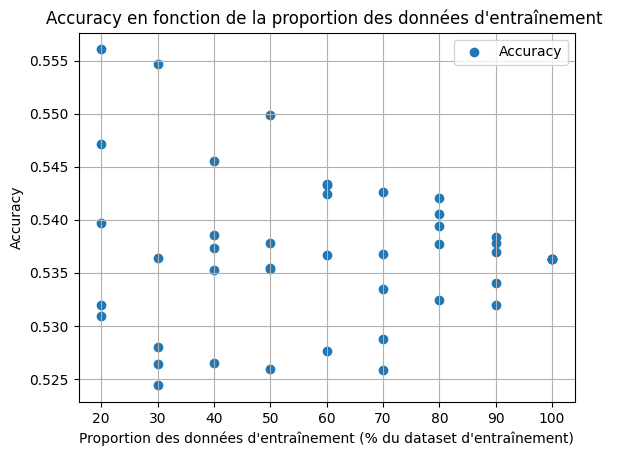

In [50]:
plt.scatter(np.array([e[0] for e in accuracies])*100, [e[1] for e in accuracies], marker='o', label="Accuracy")
plt.title("Accuracy en fonction de la proportion des données d'entraînement ")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_7334/650644794.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped_accuracies, labels=[f"{p:.0f}%" for p in unique_proportions])


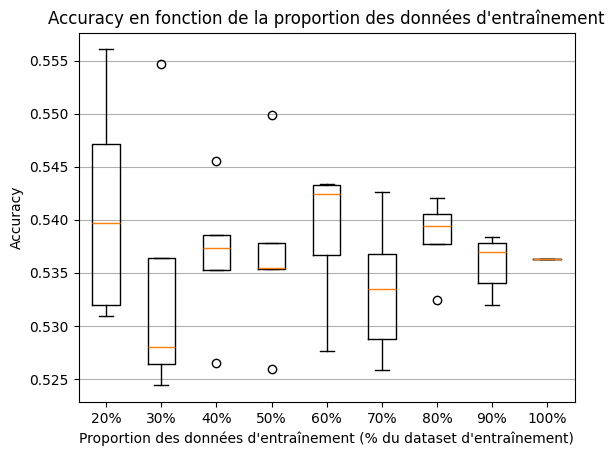

In [51]:
proportions = np.array([e[0] for e in accuracies]) * 100
accuracy_values = [e[1] for e in accuracies]


unique_proportions = sorted(set(proportions))
grouped_accuracies = [
    [accuracy_values[i] for i in range(len(proportions)) if proportions[i] == p]
    for p in unique_proportions
]

plt.boxplot(grouped_accuracies, labels=[f"{p:.0f}%" for p in unique_proportions])

plt.title("Accuracy en fonction de la proportion des données d'entraînement")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()